# **Techniki i technologie Big Data** 
## **Zespół nr 16**
### **Implementowana operacja:** sequence quality score
## **Autorzy:** 
- Michał Kopeć 311311
- Wiktor Pytlewski 304273

### Opis implementacji:

W celu zaimplementowania funkcji agregującej stworzyliśmy plik ***udafs.rs***, który zgodnie z dokumentacją powinien zawierać funkcje agregujące. Nasza funkcja ***squence_quality_score*** następnie została dodana do sesji w pliku ***context.rs***. Dodatkowo w pliku ***test_quality_score.py*** w katalogu ***tests*** został zdefiniowany prosty test jednostkowy.

# Demonstracja działania

## Test jednostkowy sprawdzający poprawność implementacji

In [18]:
!pytest -q tests/test_quality_score.py

.                                                                        [100%]
1 passed in 1.41s


## Importowanie bibliotek

In [19]:
import polars_bio as pb
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import re, pathlib, sys
import time
from datafusion import col, functions as F 

## Odczytywamie pliku FASTQ i rejestrowanie tabeli

In [20]:
pb.read_fastq("example.fastq").collect()

INFO:polars_bio:Table: example registered for path: example.fastq
200rows [00:00, 141056.13rows/s]


name,description,sequence,quality_scores
str,str,str,str
"""SRR9130495.1""","""D00236:723:HG32CBCX2:1:1108:13…","""NCAATACAAAAGCAATATGGGAGAAGCTAC…","""#4BDFDFFHGHGGJJJHIIIIGGIIJGJJG…"
"""SRR9130495.2""","""D00236:723:HG32CBCX2:1:1108:14…","""NGTCAAAGATAAGATCAAAAGGCACTGGCT…","""#1=DDDDD>DHFH@EFHHGHGGFGIIIGIG…"
"""SRR9130495.3""","""D00236:723:HG32CBCX2:1:1108:17…","""GTTTTCCTCTGGTTATTTCTAGGTACACTG…","""@@@DDDFFHHHFHBHIIGJIJIIJIIIEHG…"
"""SRR9130495.4""","""D00236:723:HG32CBCX2:1:1108:16…","""GGGAGGCGCCCCGACCGGCCAGGGCGTGAG…","""CCCFFFFFHHHHGHIIIGIIJIIIJJGHFF…"
"""SRR9130495.5""","""D00236:723:HG32CBCX2:1:1108:16…","""CACTCCGCCACTACAGCAGTCCCCCAGTGT…","""++=A1A:1ADA<;FFDC?;CG<F;::1CFI…"
…,…,…,…
"""SRR9130495.196""","""D00236:723:HG32CBCX2:1:1108:99…","""TCTTGTGAAGAAGATGCTGTTGGAAGCCTC…","""CCCFFFFFHGDFGIIJJIJJIGGJJIIJJI…"
"""SRR9130495.197""","""D00236:723:HG32CBCX2:1:1108:99…","""TGGGGCTGTGAACCGAAGTCTGCTCCTTTG…","""@BCFFDAFHHHHHIIIIHIIJIIJIIJJJI…"
"""SRR9130495.198""","""D00236:723:HG32CBCX2:1:1108:10…","""ATGTGCTCAAAGGCTGGGTGGACCTTACCT…","""@CCFFFDDFFBHDHIIIBFEGFGHGHGDFH…"


## Przeliczanie Sequence Quality Score i tworzenie ramki danych

In [21]:
t0 = time.perf_counter()  
df = pb.sql("SELECT sequence_quality_score(quality_scores) AS global_hist FROM example").collect().to_pandas()
elapsed = time.perf_counter() - t0

print(f"Wykonano w {elapsed:.3f} s")

1rows [00:00, 872.00rows/s]

Wykonano w 0.007 s


## Zagregowane dane

In [22]:
global_hist = df['global_hist']
for a in global_hist:
    print(f'{a}\n')

{"24":1,"37":49,"31":5,"30":6,"32":5,"33":10,"35":16,"39":6,"28":1,"38":41,"26":7,"34":9,"25":1,"20":1,"27":5,"29":3,"23":1,"36":33}



## Rysowanie histogramu naszego rozwiązania

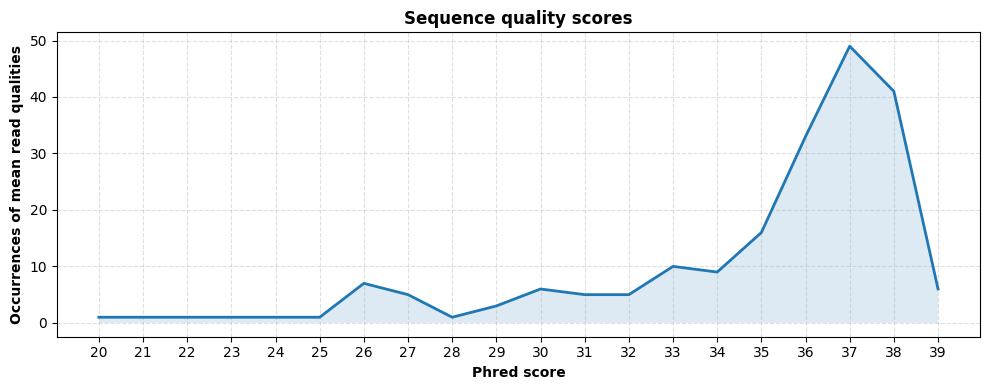

In [23]:
hist = json.loads(df.loc[0, "global_hist"])
ser  = (pd.Series(hist, dtype=int)
          .rename_axis("mean_q")
          .astype(int)
          .sort_index())

x = ser.index.to_numpy(dtype=float)
y = ser.to_numpy()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, linewidth=2)
ax.fill_between(x, y, alpha=0.15)

xmin, xmax = int(x.min()), int(x.max())
step = 1
ax.set_xticks(range(xmin, xmax + 1, step))

ax.set_xlabel("Phred score", fontweight="bold")
ax.set_ylabel("Occurrences of mean read qualities", fontweight="bold")
ax.set_title("Sequence quality scores", fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

## Wywołanie bazowego rozwiązania

In [24]:
!fqc -q example.fastq > report.html

## Rysowanie histogramu bazowego rozwiązania

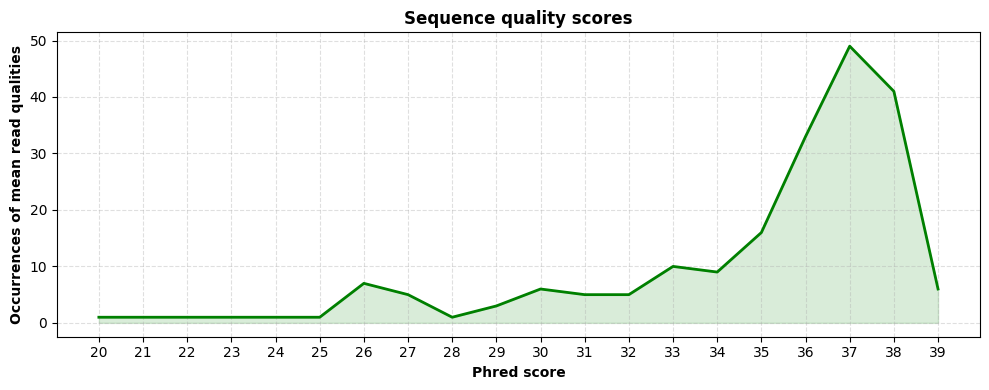

In [25]:
html_path = pathlib.Path("report.html")
if not html_path.exists():
    sys.exit("report.html not found in the current directory!")

html = html_path.read_text(encoding="utf-8", errors="ignore")

m = re.search(
    r"var\s+qualSpec\s*=\s*({.*?\"Sequence quality scores\".*?});",
    html,
    flags=re.S,
)
if not m:
    sys.exit("Nie znaleziono bloku 'qualSpec' w report.html")

qual_json_str = m.group(1)
qual_spec = json.loads(qual_json_str)

values = qual_spec["data"]["values"]
df_fqc = pd.DataFrame(values).sort_values("score")

x = df_fqc["score"].to_numpy(dtype=float)
y = df_fqc["count"].to_numpy(dtype=float)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, linewidth=2, color='green')
ax.fill_between(x, y, alpha=0.15, color='green')

ax.set_xticks(np.arange(int(x.min()), int(x.max()) + 1, 1))
ax.set_xlabel("Phred score", fontweight="bold")
ax.set_ylabel("Occurrences of mean read qualities", fontweight="bold")
ax.set_title("Sequence quality scores", fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# **Test na większym pliku**

## Odczytywamie pliku FASTQ i rejestrowanie tabeli

In [26]:
pb.read_fastq("ERR194147.fastq").collect()

INFO:polars_bio:Table: err194147 registered for path: ERR194147.fastq
8240796rows [00:44, 185901.75rows/s]


name,description,sequence,quality_scores
str,str,str,str
"""ERR194147.787265110""","""HSQ1004:134:C0D8DACXX:1:1206:1…","""GAATGGAATCGAATGGAATCATCATCGAAT…","""CCCFFFFFHHHHHJJJJJJJJJJJJIJIJJ…"
"""ERR194147.787265111""","""HSQ1004:134:C0D8DACXX:1:2304:5…","""TAATCAACCAATTTTATATATTGTTATTAA…",""";?;DD4A?A?D?DBBE@ECH@B<EH4A?,A…"
"""ERR194147.787265112""","""HSQ1004:134:C0D8DACXX:3:2108:1…","""TCATTTCTAAAACATGTCAAGTCCTTCCAC…","""CCCFFFFFHHHHHJJJJJJIJIIIJIJJJJ…"
"""ERR194147.787265113""","""HSQ1004:134:C0D8DACXX:1:1305:1…","""GTGGAACCATAGAATGAACACGAAATGAAT…","""@;@D?DDDHHHFHIDGII<FBGHEG=<:C?…"
"""ERR194147.787265114""","""HSQ1004:134:C0D8DACXX:3:2202:1…","""GGTGAGAGTTAAGCAGTAAAACCATGACCC…","""@BBDDFFFFHHHHJJJHIJJJJJJJJJJJJ…"
…,…,…,…
"""ERR194147.795505901""","""HSQ1004:134:C0D8DACXX:1:1303:1…","""AAATAAGTAGGCTTTGCCCACTGGTCTTCT…","""CCCFFFFFHHHHHJJJJJJJJJJJFHGJJJ…"
"""ERR194147.795505902""","""HSQ1004:134:C0D8DACXX:3:1106:1…","""AACTTCTTTGTGATGTGTGCGTTGAACCCA…","""CCCFFFFFHGHHHJJIJHHIJJJJJJJJJJ…"
"""ERR194147.795505903""","""HSQ1004:134:C0D8DACXX:3:1203:1…","""CTGTAGAAATGAGATGAATAATTAAGAACA…","""CCCDFFFFHHHHHJJJJIJJJJJJJJJJJJ…"


## Przeliczanie Sequence Quality Score i tworzenie ramki danych

In [27]:
t0 = time.perf_counter()  
df = pb.sql("SELECT sequence_quality_score(quality_scores) AS global_hist FROM ERR194147").collect().to_pandas()
elapsed = time.perf_counter() - t0

print(f"Wykonano w {elapsed:.3f} s")

0rows [00:00, ?rows/s]

1rows [00:07,  7.52s/rows]

Wykonano w 7.542 s


## Zagregowane dane

In [28]:
global_hist = df['global_hist']
for a in global_hist:
    print(f'{a}\n')

{"32":165004,"33":213732,"34":291527,"15":3650,"40":84373,"37":1389401,"12":605,"39":1376995,"16":5578,"9":25,"19":11662,"20":13928,"36":702581,"8":6,"38":2897993,"17":7958,"27":58771,"18":9456,"26":47541,"13":1252,"35":424595,"21":17095,"23":25624,"29":87646,"25":38769,"14":2177,"11":269,"7":5,"28":71264,"31":131861,"10":96,"22":20904,"24":31761,"30":106692}



## Rysowanie histogramu naszego rozwiązania

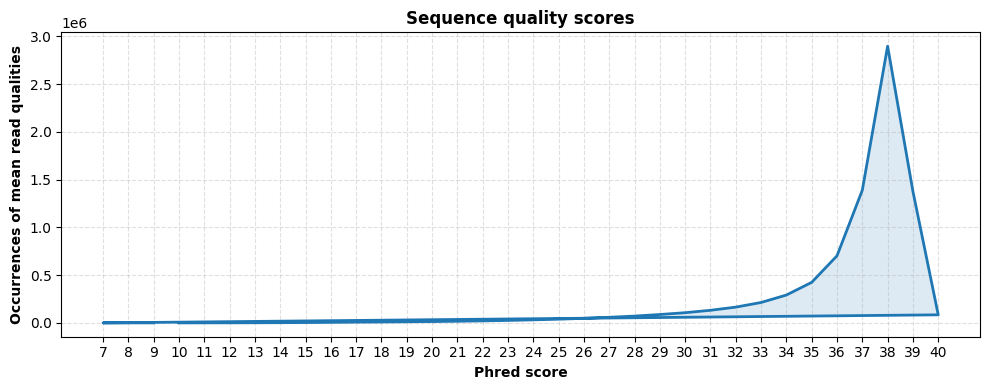

In [29]:
hist = json.loads(df.loc[0, "global_hist"])
ser  = (pd.Series(hist, dtype=int)
          .rename_axis("mean_q")
          .astype(int)
          .sort_index())

x = ser.index.to_numpy(dtype=float)
y = ser.to_numpy()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, linewidth=2)
ax.fill_between(x, y, alpha=0.15)

xmin, xmax = int(x.min()), int(x.max())
step = 1
ax.set_xticks(range(xmin, xmax + 1, step))

ax.set_xlabel("Phred score", fontweight="bold")
ax.set_ylabel("Occurrences of mean read qualities", fontweight="bold")
ax.set_title("Sequence quality scores", fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

## Wywołanie bazowego rozwiązania

In [15]:
!fqc -q ERR194147.fastq > report_big.html

## Rysowanie histogramu bazowego rozwiązania

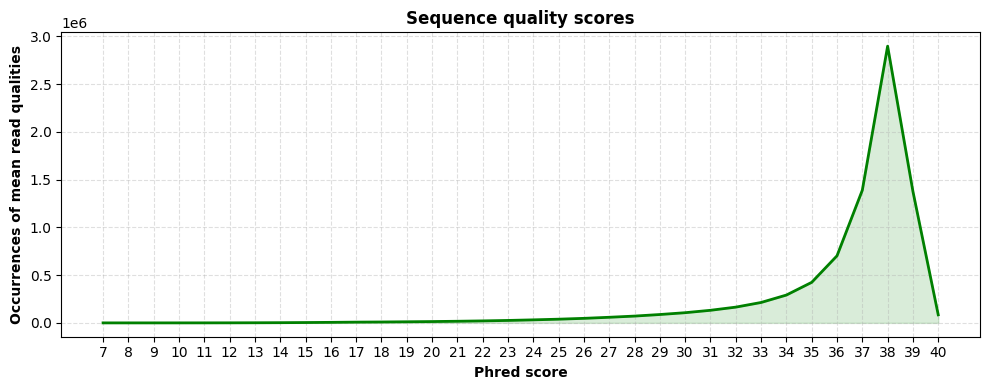

In [30]:
html_path = pathlib.Path("report_big.html")
if not html_path.exists():
    sys.exit("report.html not found in the current directory!")

html = html_path.read_text(encoding="utf-8", errors="ignore")

m = re.search(
    r"var\s+qualSpec\s*=\s*({.*?\"Sequence quality scores\".*?});",
    html,
    flags=re.S,
)
if not m:
    sys.exit("Nie znaleziono bloku 'qualSpec' w report.html")

qual_json_str = m.group(1)
qual_spec = json.loads(qual_json_str)

values = qual_spec["data"]["values"]
df_fqc = pd.DataFrame(values).sort_values("score")

x = df_fqc["score"].to_numpy(dtype=float)
y = df_fqc["count"].to_numpy(dtype=float)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, linewidth=2, color='green')
ax.fill_between(x, y, alpha=0.15, color='green')

ax.set_xticks(np.arange(int(x.min()), int(x.max()) + 1, 1))
ax.set_xlabel("Phred score", fontweight="bold")
ax.set_ylabel("Occurrences of mean read qualities", fontweight="bold")
ax.set_title("Sequence quality scores", fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()